인공지능학과 2021020381 한소현

# 1. Convolutionalization을 이용하여 간단한 detection 작업을 수행한다.

In [1]:
# 랜덤 시드 설정
import numpy as np
import tensorflow as tf
from sklearn import datasets
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from sklearn.datasets import fetch_openml # loading data
import pandas as pd
import copy
np.random.seed(1004)
tf.random.set_seed(1004)

In [2]:
# 데이터 불러오기
mnist = fetch_openml('mnist_784') # mnist.data.shape : (70000, 784) / mnist.target.shape : (70000,)

mnist_1 = np.asarray(mnist.data).reshape(-1, 28, 28, 1) # (70000, 28, 28 , 1)
mnist_2 = mnist_1.reshape(-1, 4, 4, 28, 28).transpose(0, 1, 3, 2, 4) # (4375, 4, 4, 28, 28) -> (4375, 4, 28, 4, 28)
mnist_4by4 = mnist_2.reshape(-1, 28*4, 28*4) # (4375, 112, 112)
mnist_4_4 = mnist_4by4.reshape(-1, 28*4, 28*4, 1) # (4375, 112, 112, 1)

class_num = len(np.unique(mnist.target)) # 10
label = to_categorical(mnist.target)
# train, test 데이터 나누기
x_train, x_test, y_train, y_test = train_test_split(mnist_1, label) # x_train : (52500, 28, 28, 1) / y_train : (52500, 10)

그림 그려보기

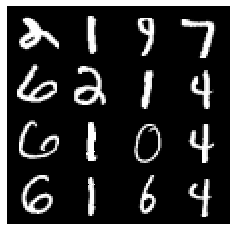

In [3]:
k = np.random.randint(mnist_4by4.shape[0]) # 무작위로 그림 하나 그리기
plt.figure(num=0, figsize = [4, 4])
plt.pcolor(mnist_4by4[k], cmap='gray')
plt.gca().invert_yaxis()
plt.axis('off')
plt.show()

## Classification model

In [4]:
epoch = 10
batch_size = 64
lr = 1e-4

model1 = Sequential()
model1.add(Conv2D(kernel_size=(20,20), filters=64, padding="valid", input_shape=(28,28,1)))
model1.add(BatchNormalization())
model1.add(Conv2D(kernel_size=(9,9), filters=10, padding="valid"))
model1.add(Activation('relu'))
model1.add(Activation('Softmax'))
model1.add(Flatten())

# model1.summary()
model1.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=lr), metrics=['accuracy'])

In [5]:
hist_model = model1.fit(x_train, y_train, epochs=epoch, batch_size=batch_size, verbose=0)
scores_train = model1.evaluate(x_train, y_train)
scores_test = model1.evaluate(x_test, y_test)

print("\n========================   Results   ========================")
print("Train data accuracy %s: %.2f%%" % (model1.metrics_names[1], scores_train[1]*100))
print("Test data accuracy %s: %.2f%%" % (model1.metrics_names[1], scores_test[1]*100))

547/547 [==============================] - 1s 2ms/step - loss: 0.2850 - accuracy: 0.9213

========================   Results   ========================
Train data accuracy accuracy: 93.02%
Test data accuracy accuracy: 92.13%


## Convolutionalization

In [6]:
pred = model1.predict(mnist_4_4) # (4375, 72250)
pred = pred.reshape(-1, 85, 85, 10) # (4375, 85, 85, 10)

to_detect = to_categorical(np.asarray(mnist.target).reshape(-1, 4, 4)) # mnist_4by4 : (4375, 112, 112) # to_detect : (4, 4, 10)

x_train2, x_test2, y_train2, y_test2 = train_test_split(pred, to_detect, shuffle=False)

In [7]:
model2 = Sequential()
model2.add(Conv2D(kernel_size=(10, 10), strides=(7, 7), filters=100, padding="valid", input_shape=(85,85,10)))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(Conv2D(kernel_size=(8, 8), filters=10, padding='valid'))
model2.add(Activation('softmax'))

model2.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=lr), metrics=['accuracy'])
# model2.summary()

In [8]:
hist_model2 = model2.fit(x_train2, y_train2, epochs=epoch, batch_size=batch_size, verbose=0)
scores_train2 = model2.evaluate(x_train2, y_train2)
scores_test2 = model2.evaluate(x_test2, y_test2)

print("\n========================   Results   ========================")
print("Train data accuracy %s: %.2f%%" % (model2.metrics_names[1], scores_train2[1]*100))
print("Test data accuracy %s: %.2f%%" % (model2.metrics_names[1], scores_test2[1]*100))

35/35 [==============================] - 0s 7ms/step - loss: 1.3543 - accuracy: 0.5859

========================   Results   ========================
Train data accuracy accuracy: 70.17%
Test data accuracy accuracy: 58.59%


In [9]:
def to_detect(target_num):
    pd = np.asarray(model2.predict(x_test2[10].reshape(1,85,85,10)))
    t1, t2 = train_test_split(mnist_4by4, shuffle=False)
    x = np.argmax(pd,-1).reshape(4,4)
    for i in range(4):
        for j in range(4):
            if x[i,j] == target_num:
                x[i,j] = 0
            else:
                x[i,j] = 1

    plt.figure(num=0, figsize = [4, 4])
    plt.pcolor(t2[10], cmap='gray')
    plt.gca().invert_yaxis()
    plt.axis('off')
    plt.show()

    plt.figure(num=0, figsize = [4, 4])
    plt.pcolor(x, cmap='gray', edgecolor='black')
    plt.gca().invert_yaxis()
    plt.axis('off')
    plt.show()

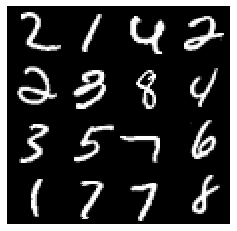

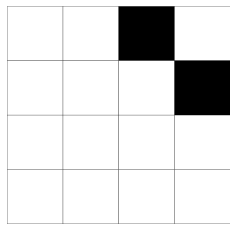

In [10]:
to_detect(4) # 4를 detection 해보자!

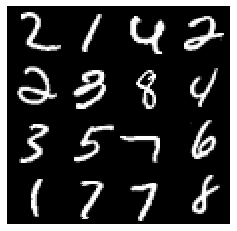

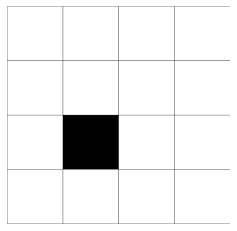

In [11]:
to_detect(5) # 5를 detection 해보자!

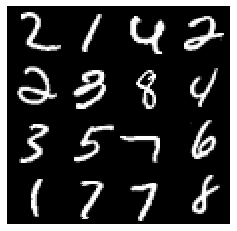

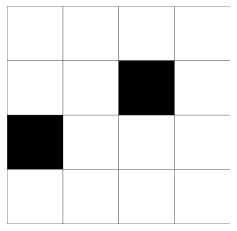

In [12]:
to_detect(8) # 8를 detection 해보자!

성능이 우수하지 않아서, 모두를 다 맞추지는 않지만, 대체적으로 detection을 수행하는 것을 볼 수 있다.

# 2. One to Many 구조의 RNN full gradient 계산 방식을 코딩하고 테스트한다.

500 -th epoch trained


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:115: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later


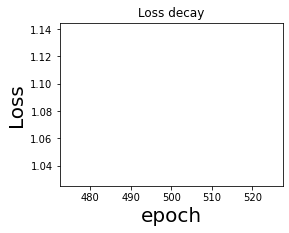

1000 -th epoch trained


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:115: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later


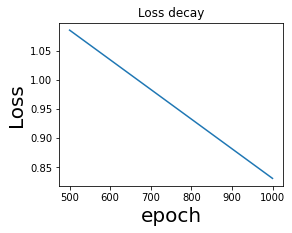

1500 -th epoch trained


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:115: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later


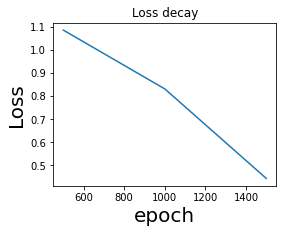

2000 -th epoch trained


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:115: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later


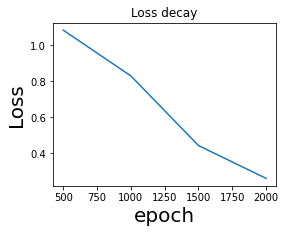

2500 -th epoch trained


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:115: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later


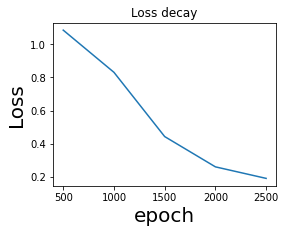

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:115: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later


3000 -th epoch trained


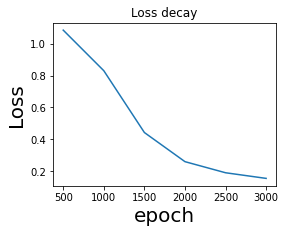

3500 -th epoch trained


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:115: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later


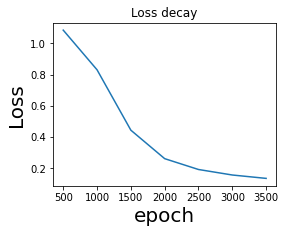

4000 -th epoch trained


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:115: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later


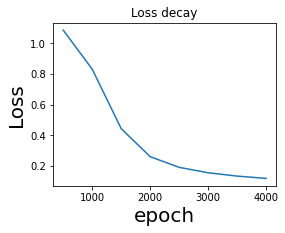

4500 -th epoch trained


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:115: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later


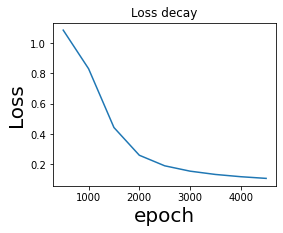

5000 -th epoch trained


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:115: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later


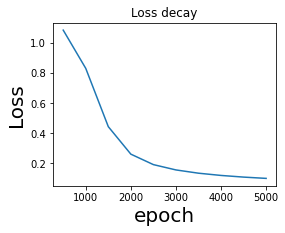

5500 -th epoch trained


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:115: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later


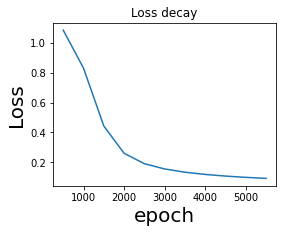

6000 -th epoch trained


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:115: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later


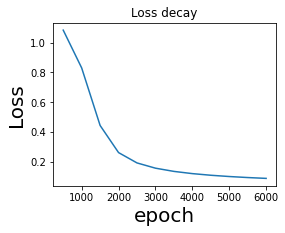

6500 -th epoch trained


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:115: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later


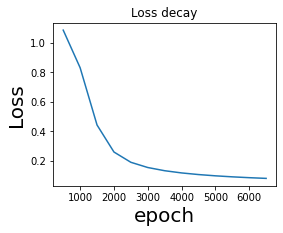

7000 -th epoch trained


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:115: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later


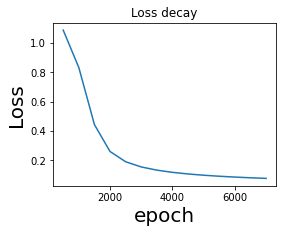

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:115: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later


7500 -th epoch trained


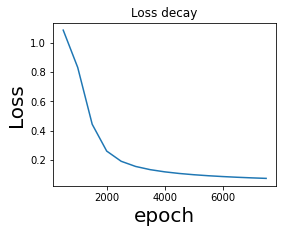

8000 -th epoch trained


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:115: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later


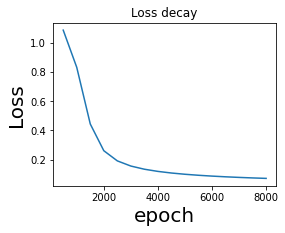

8500 -th epoch trained


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:115: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later


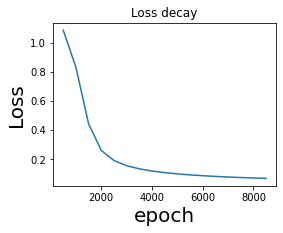

9000 -th epoch trained


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:115: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later


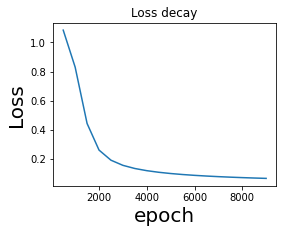

9500 -th epoch trained


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:115: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later


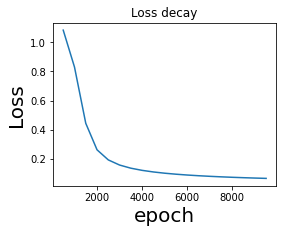

[array([0.00867046, 0.97677631, 0.01495495, 0.01539552]), array([2.30158106e-03, 1.90431855e-02, 9.93903370e-01, 2.29597473e-04]), array([0.0046551 , 0.00170107, 0.9761923 , 0.02355145]), array([0.00539107, 0.00791352, 0.02238267, 0.97358192])]


In [13]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# HELLO ! --> H:[1 0 0 0], E:[0 1 0 0], L:[0 0 1 0], O:[0 0 0 1]
H=[1,0,0,0]; E=[0,1,0,0]; L=[0,0,1,0]; O=[0,0,0,1]
output = [E, L, L, O]
input = [H] 

N = np.size(input, 0) # number of samples
Ni = np.size(input, 1) # dimension of the samples of input
Nh = 30 # number of hidden units
No = 4 # dimension of the sample of output
Nh2 = 10 # number of hidden units

W = 2/np.sqrt(Ni)*(np.random.rand(Nh,Ni) - 0.5) # Xavier initialization
V = 2/np.sqrt(Nh)*(np.random.rand(Nh,Nh) - 0.5) # Xavier initialization
Wo = 2/np.sqrt(Nh)*(np.random.rand(No,Nh) - 0.5)  # Xavier initialization

alpha = 0.05 # Learning rate
t_ = []; loss_ = []

def sigmoid(x):
    f = 1/(1+np.exp(-x))
    return f

### train
h0 = np.zeros(Nh)
for epoch in range(0, 10000):
    loss = 0
    h = [h0]
    y = []
    for id_ in range(0,N):   # Forward pass
        x = input[id_]
        v1 = sigmoid(np.dot(W, x) + np.dot(V, h[-1]))
        y1 = sigmoid(np.dot(Wo, v1))
        y.append(y1); h.append(v1)

        v2 = sigmoid(np.dot(W, y1) + np.dot(V, h[-1]))
        y2 = sigmoid(np.dot(Wo, v2))
        y.append(y2); h.append(v2)

        v3 = sigmoid(np.dot(W, y2) + np.dot(V, h[-1]))
        y3 = sigmoid(np.dot(Wo, v3))
        y.append(y3); h.append(v3)

        v4 = sigmoid(np.dot(W, y3) + np.dot(V, h[-1]))
        y4 = sigmoid(np.dot(Wo, v4))
        y.append(y4)

    for id__ in range(0,N):   # Backward pass
        id_ = N-1 - id__
        ###
        # delta rule
        e = y4 - output[-1]
        delta = y4 * (1 - y4) * e

        e1 = np.dot(np.transpose(Wo), delta)
        delta1 = v4 * (1 - v4) * e1
        
        Wo = Wo - alpha*np.dot(np.transpose([delta]),[v4])
        V = V - alpha*np.dot(np.transpose([delta1]),[v3])

        loss += 1/2*np.linalg.norm(e)
        ### 두 번째 부터는 양쪽에서 delta rule 적용
        e = y3 - output[-2]
        delta = y3 * (1 - y3) * e

        e1 = np.dot(np.transpose(Wo), delta)
        e2 = np.dot(np.transpose(V), delta1)
        delta2 = v3 * (1 - v3) * e2 + v3 * (1 - v3) * e1

        Wo = Wo - alpha*np.dot(np.transpose([delta]),[v3])
        V = V - alpha*np.dot(np.transpose([delta2]),[v2])

        loss += 1/2*np.linalg.norm(e)
        ###  
        e = y2 - output[-3]
        delta = y2 * (1 - y2) * e

        e1 = np.dot(np.transpose(Wo), delta)
        e2 = np.dot(np.transpose(V),delta2)
        delta3 = v2*(1-v2)*e2 + v2*(1-v2)*e1

        Wo = Wo - alpha*np.dot(np.transpose([delta]),[v2])
        V = V - alpha*np.dot(np.transpose([delta3]),[v1])

        loss += 1/2*np.linalg.norm(e)
        ###
        e = y1 - output[0]
        delta = y1 * (1-y1) * e

        e1 = np.dot(np.transpose(Wo), delta)
        e2 = np.dot(np.transpose(V),delta3)        
        delta4 = v1 * (1 - v1) * e2 + h0 * (1 - h0) * e1

        W = W - alpha*np.dot(np.transpose([delta4]),[x])
        Wo = Wo - alpha*np.dot(np.transpose([delta]),[v1])

        loss += 1/2*np.linalg.norm(e)
    
    # 시각화하기
    if np.mod(epoch, 500) == 0:
        if epoch == 0:
            continue
        print(epoch,"-th epoch trained")
            
        t_ = np.append(t_,epoch)
        loss_ = np.append(loss_,loss)
        
        plt.figure(num=0, figsize = [4, 3])
        plt.plot(t_,loss_,marker="")
        plt.title('Loss decay')
        plt.xlabel('epoch',FontSize=20)
        plt.ylabel('Loss',FontSize=20)
        plt.show()
        print('====================================================================')

### test
y=[]
h=[h0]
for id_ in range(0,N):
    x = input[id_]
    v1 = np.dot(W, x) + np.dot(V, h[-1])
    v1 = sigmoid(v1)
    y1 = sigmoid(np.dot(Wo, v1))
    y.append(y1); h.append(v1)

    v2 = np.dot(W, y1) + np.dot(V, h[-1])
    v2 = sigmoid(v2)
    y2 = sigmoid(np.dot(Wo, v2))
    y.append(y2); h.append(v2)

    v3 = np.dot(W, y2) + np.dot(V, h[-1])
    v3 = sigmoid(v3)
    y3 = sigmoid(np.dot(Wo, v3))
    y.append(y3); h.append(v3)

    v4 = np.dot(W, y3) + np.dot(V, h[-1])
    v4 = sigmoid(v4)
    y4 = sigmoid(np.dot(Wo, v4)); y.append(y4)        

    print(y)

In [14]:
max_index = np.argmax(y, axis=1)
print(max_index)
# HELLO ! --> H:[1 0 0 0], E:[0 1 0 0], L:[0 0 1 0], O:[0 0 0 1]

[1 2 2 3]


max_index의 값들이 [1 2 2 3]으로 'E' 'L' 'L' 'O'가 제대로 출력되는 것을 볼 수 있다.

# 3. Delta-rule을 활용하여 LSTM을 코딩하고 테스트한다.

In [15]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Dense

In [16]:
use_words = 500 # 상위 500개의 데이터만을 이용
(train_x, train_y), (test_x, test_y) = imdb.load_data(num_words=use_words) # 데이터 로드
train_x = sequence.pad_sequences(train_x, maxlen=50) # 일정한 길이로 맞춰줄 때 사용하는 함수
test_x = sequence.pad_sequences(test_x, maxlen=50)

# LSTM 모델 생성
model = Sequential()
model.add(Embedding(use_words, 32, input_length=50))
model.add(LSTM(50)) # LSTM 사용
model.add(Dense(1, activation='sigmoid')) # delta-rule을 위해 sigmoid 추가
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(train_x, train_y, validation_data=(test_x, test_y), epochs=3, batch_size=128)

# Final evaluation of the model
scores = model.evaluate(test_x, test_y, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Epoch 1/3
196/196 [==============================] - 12s 58ms/step - loss: 0.5739 - accuracy: 0.6895 - val_loss: 0.5028 - val_accuracy: 0.7548
Epoch 2/3
196/196 [==============================] - 11s 57ms/step - loss: 0.4934 - accuracy: 0.7574 - val_loss: 0.4879 - val_accuracy: 0.7626
Epoch 3/3
196/196 [==============================] - 11s 56ms/step - loss: 0.4811 - accuracy: 0.7654 - val_loss: 0.4778 - val_accuracy: 0.7653
Accuracy: 76.53%


sigmoid 함수는 미분을 하면 매우 편리한 성질을 가지고 있다.
$f(x) = Sigmoid(x)$로 정의를 했을 때, $f'(x) = f(x)(1 - f(x))$이다.
역전파에 사용하는 델타를 쉽게 계산할 수 있다.

# 4. GAN을 수업시간에 활용하지 않은 데이터로 구현한다.

GAN network 생성

In [17]:
class GAN(tf.keras.Model): 
    def __init__(self, **kwargs):
        super(GAN, self).__init__()
        self.__dict__.update(kwargs)
        self.gen = tf.keras.Sequential(self.gen)
        self.disc = tf.keras.Sequential(self.disc)

    def generate(self, z):
        return self.gen(z)

    def discriminate(self, x):
        return self.disc(x)

    def compute_loss(self, x):
        z_samp = tf.random.normal([x.shape[0], 1, 1, self.n_Z]) # uniform 분포에서 noise 생성

        x_gen = self.generate(z_samp) # generator
        logits_x = self.discriminate(x) # discriminator
        logits_x_gen = self.discriminate(x_gen)
        
        # losses
        disc_real_loss = gan_loss(logits=logits_x, is_real=True) # label 1일 때 loss
        disc_fake_loss = gan_loss(logits=logits_x_gen, is_real=False) # label 0일 때 loss
        disc_loss = disc_fake_loss + disc_real_loss
        gen_loss = gan_loss(logits=logits_x_gen, is_real=True) # fake
        return disc_loss, gen_loss

    def compute_gradients(self, x):
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            disc_loss, gen_loss = self.compute_loss(x)

        gen_gradients = gen_tape.gradient(gen_loss, self.gen.trainable_variables)
        disc_gradients = disc_tape.gradient(disc_loss, self.disc.trainable_variables)

        return gen_gradients, disc_gradients

    def apply_gradients(self, gen_gradients, disc_gradients):
        self.gen_optimizer.apply_gradients(zip(gen_gradients, self.gen.trainable_variables))
        self.disc_optimizer.apply_gradients(zip(disc_gradients, self.disc.trainable_variables))
    @tf.function
    def train(self, train_x):
        gen_gradients, disc_gradients = self.compute_gradients(train_x)
        self.apply_gradients(gen_gradients, disc_gradients)
        
def gan_loss(logits, is_real=True):
    if is_real: labels = tf.ones_like(logits)
    else: labels = tf.zeros_like(logits)

    return tf.compat.v1.losses.sigmoid_cross_entropy(multi_class_labels=labels, logits=logits)

In [18]:
TRAIN_NUM=60000; TEST_NUM=10000
BATCH_SIZE=512; DIMS = (28,28,1)
N_TRAIN_BATCHES =int(TRAIN_NUM/BATCH_SIZE)
N_TEST_BATCHES = int(TEST_NUM/BATCH_SIZE)

# load dataset
(train_images, _), (test_images, _) = tf.keras.datasets.fashion_mnist.load_data()

# split dataset
train_data = train_images.reshape(train_images.shape[0], 28, 28, 1).astype("float32") / 255.0
test_data = test_images.reshape(test_images.shape[0], 28, 28, 1).astype("float32") / 255.0

# batch datasets
train_dataset = (tf.data.Dataset.from_tensor_slices(train_data).shuffle(TRAIN_NUM).batch(BATCH_SIZE))
test_dataset = (tf.data.Dataset.from_tensor_slices(test_data).shuffle(TEST_NUM).batch(BATCH_SIZE))

In [19]:
N_Z = 64
generator = [
    tf.keras.layers.Dense(units=7 * 7 * 64, activation="relu"),
    tf.keras.layers.Reshape(target_shape=(7, 7, 64)),
    tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=(2, 2), padding="SAME", activation="relu"),
    tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=(2, 2), padding="SAME", activation="relu"),
    tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=3, strides=(1, 1), padding="SAME", activation="sigmoid"),
]

discriminator = [
    tf.keras.layers.InputLayer(input_shape=DIMS),
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=(2, 2), activation="relu"),
    tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2, 2), activation="relu"),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=1, activation=None),
]

Epoch: 0 ||             disc_loss: 0.2756209671497345 ||             gan_loss: 1.9785276651382446


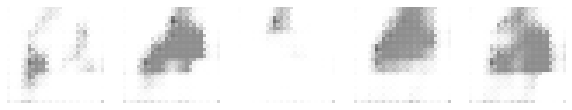

Epoch: 5 ||             disc_loss: 1.218164086341858 ||             gan_loss: 3.4365968704223633


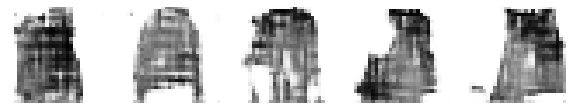

Epoch: 10 ||             disc_loss: 0.6677747368812561 ||             gan_loss: 1.5201503038406372


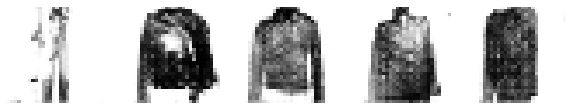

Epoch: 15 ||             disc_loss: 0.5817362666130066 ||             gan_loss: 1.5366939306259155


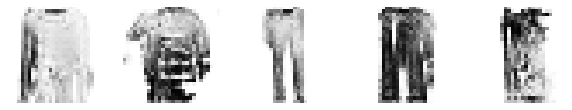

Epoch: 20 ||             disc_loss: 0.6763351559638977 ||             gan_loss: 2.331650495529175


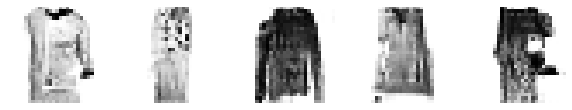

Epoch: 25 ||             disc_loss: 0.7607194781303406 ||             gan_loss: 2.406362533569336


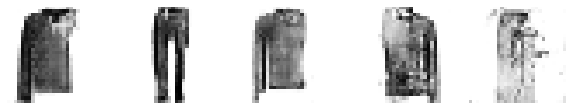

In [20]:
# optimizers
gen_optimizer = tf.keras.optimizers.Adam(0.001, beta_1=0.5)
disc_optimizer = tf.keras.optimizers.RMSprop(0.01) # 모델 train

model = GAN(gen = generator, disc = discriminator, gen_optimizer = gen_optimizer, disc_optimizer = disc_optimizer, n_Z = N_Z)

n_epochs = 30
losses = pd.DataFrame(columns = ['disc_loss', 'gen_loss'])
for epoch in range(n_epochs):
    # train
    for batch, train_x in zip(range(N_TRAIN_BATCHES), train_dataset):
        model.train(train_x)
    # test
    loss = []
    for batch, test_x in zip(range(N_TEST_BATCHES), test_dataset):
        loss.append(model.compute_loss(train_x))
    losses.loc[len(losses)] = np.mean(loss, axis=0)
    
    if epoch % 5 == 0:
        print(f"Epoch: {epoch} || \
            disc_loss: {losses.disc_loss.values[-1]} || \
            gan_loss: {losses.gen_loss.values[-1]}")
        draw = model.generate(tf.random.normal(shape=(BATCH_SIZE, N_Z)))
        fig, axs = plt.subplots(ncols=5, nrows=1, figsize=(10, 2))
        for axi in range(5):
            axs[axi].matshow(draw.numpy()[axi].squeeze(), cmap=plt.cm.Greys, vmin=0, vmax=1)
            axs[axi].axis('off')
        plt.show()

epoch이 증가할수록 더 좋은 사진을 생성하는 것을 볼 수 있다.